In [4]:
# define logging and working directory
# define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.notebook_imports import *
from pyforest import *

from sklearn.manifold import TSNE


# define GPU id to use
# 0 = 1080 Bus ID 2
# 1 = Titan Bus ID 131
# 2 = Titan Bus ID 132
GPU_IDS = '0,1'
current_gpu = choose_gpu_by_id(GPU_IDS)
print(current_gpu)

%matplotlib inline
%reload_ext autoreload
%autoreload 2

from src.utils.utils_io import Console_and_file_logger, ensure_dir
from src.utils.myshow import myshow, myshow3d
from src.visualization.visualize import plot_3d_vol, plot_4d_vol, show_slice, show_slice_transparent
from src.data.dataset import get_metadata_maybe, filter_4d_vol, describe_sitk
from src.data.dataset import get_img_msk_files_from_split_dir, load_acdc_files
from src.data.generators import DataGenerator, get_samples
from src.utils.KerasCallbacks import get_callbacks
from keras.utils import plot_model
from src.models.vae import get_vae
Console_and_file_logger('2D_VAE_tests', logging.INFO)

search for root_dir and set working directory
Working directory set to: /mnt/data/git/cardio


Using TensorFlow backend.
2019-10-09 15:33:30,684 INFO -------------------- Start --------------------
2019-10-09 15:33:30,685 INFO Working directory: /mnt/data/git/cardio.
2019-10-09 15:33:30,685 INFO Log file: ./logs/2D_VAE_tests.log


['gpu(0)', 'gpu(1)']


In [4]:
# create a config
EXPERIMENT = '2D/tetra/vae_rising'
now = datetime.datetime.now()
# image params
DIM = [224, 224]
SPACING = [1.0,1.0] # used by sitk, opposite order than numpy or tensorflow!
# Greyscale images
IMG_CHANNELS = 1
# RV = 1 = Y[...,0] 
# Myo = 2 = Y[...,1] 
# LV = 3 = Y[...,2]
MASK_VALUES = [0, 1, 2, 3]  
MASK_CLASSES = len(MASK_VALUES)
ARCHITECTURE = '2D'
AUGMENT = False
SHUFFLE = True
AUGMENT_GRID = False
SEED = 42
BATCHSIZE =  64 # 64, 16, 1
SCALER = 'MinMax'
EPOCHS = 150

SINGLE_OUTPUT = True

MSE = False 
WEIGHTS = False

# path params
DATASET = 'acdc'  # 'acdc' # or 'tetra'
TRAIN_PATH = 'data/raw/tetra/2D/train/'
VAL_PATH = 'data/raw/tetra/2D/val/'
TEST_PATH = 'data/raw/tetra/2D/test/'

MODEL_PATH = os.path.join(os.path.join('models', EXPERIMENT), str(now.strftime("%Y-%m-%d_%H_%M")))
TENSORBOARD_LOG_DIR = os.path.join(os.path.join('reports/tensorboard_logs', EXPERIMENT),str(now.strftime("%Y-%m-%d_%H_%M")))
CONFIG_PATH = os.path.join(os.path.join('reports/configs/',EXPERIMENT),str(now.strftime("%Y-%m-%d_%H_%M")))
HISTORY_PATH = os.path.join(os.path.join('reports/history/',EXPERIMENT),str(now.strftime("%Y-%m-%d_%H_%M")))



config = dict(((key, value) for key, value in locals().items()
               if key.isupper() and key not in ['HTML', 'K']))
config

{'TSNE': sklearn.manifold.t_sne.TSNE,
 'GPU_IDS': '0,1',
 'EXPERIMENT': '2D/tetra/vae_rising',
 'DIM': [224, 224],
 'SPACING': [1.0, 1.0],
 'IMG_CHANNELS': 1,
 'MASK_VALUES': [0, 1, 2, 3],
 'MASK_CLASSES': 4,
 'ARCHITECTURE': '2D',
 'AUGMENT': False,
 'SHUFFLE': True,
 'AUGMENT_GRID': False,
 'SEED': 42,
 'BATCHSIZE': 64,
 'SCALER': 'MinMax',
 'EPOCHS': 150,
 'SINGLE_OUTPUT': True,
 'MSE': False,
 'WEIGHTS': False,
 'DATASET': 'acdc',
 'TRAIN_PATH': 'data/raw/tetra/2D/train/',
 'VAL_PATH': 'data/raw/tetra/2D/val/',
 'TEST_PATH': 'data/raw/tetra/2D/test/',
 'MODEL_PATH': 'models/2D/tetra/vae_rising/2019-10-09_09_14',
 'TENSORBOARD_LOG_DIR': 'reports/tensorboard_logs/2D/tetra/vae_rising/2019-10-09_09_14',
 'CONFIG_PATH': 'reports/configs/2D/tetra/vae_rising/2019-10-09_09_14',
 'HISTORY_PATH': 'reports/history/2D/tetra/vae_rising/2019-10-09_09_14'}

In [65]:
"""
2D samples or data from special lower, mid, upper area
# load only slices from the lower, middle or upper part
X_train, Y_train = get_samples(path=TRAIN_PATH, samples=0, part='all', no_patients = 0, preprocessed=False)
X_val, Y_val = get_samples(path=VAL_PATH, samples=0, part='all', no_patients = 0, preprocessed=False)
X_test, Y_test = get_samples(path=TEST_PATH, samples=0, part='all', no_patients = 0, preprocessed=False)
"""


#3D ACDC files - combine GCN and ACDC dataset
x_train_acdc, y_train_acdc = get_img_msk_files_from_split_dir('data/raw/ACDC/2D/train')
x_val_acdc, y_val_acdc = get_img_msk_files_from_split_dir('data/raw/ACDC/2D/val')
x_test_acdc, y_test_acdc = get_img_msk_files_from_split_dir('data/raw/ACDC/2D/val')
print(len(x_train_acdc))

x_train_gcn, y_train_gcn = get_img_msk_files_from_split_dir('data/raw/tetra/2D/train')
x_val_gcn, y_val_gcn = get_img_msk_files_from_split_dir('data/raw/tetra/2D/val')
x_test_gcn, y_test_gcn = get_img_msk_files_from_split_dir('data/raw/tetra/2D/test')
print(len(x_train_gcn))

x_train = x_train_acdc + x_train_gcn
y_train = y_train_acdc + y_train_gcn

x_val = x_val_acdc + x_val_gcn
y_val = y_val_acdc + y_val_gcn

x_test = x_test_acdc + x_test_gcn
y_test = y_test_acdc + y_test_gcn


logging.info('x_train files: {}, y_train files: {}'.format(len(x_train), len(y_train)))
logging.info('x_val files: {}, y_val files: {}'.format(len(x_val), len(y_val)))
logging.info('x_test files: {}, y_test files: {}'.format(len(x_test), len(y_test)))

"\n2D samples or data from special lower, mid, upper area\n# load only slices from the lower, middle or upper part\nX_train, Y_train = get_samples(path=TRAIN_PATH, samples=0, part='all', no_patients = 0, preprocessed=False)\nX_val, Y_val = get_samples(path=VAL_PATH, samples=0, part='all', no_patients = 0, preprocessed=False)\nX_test, Y_test = get_samples(path=TEST_PATH, samples=0, part='all', no_patients = 0, preprocessed=False)\n"

2019-09-25 16:48:32,257 INFO x_train files: 11792, y_train files: 11792
2019-09-25 16:48:32,258 INFO x_val files: 2322, y_val files: 2322
2019-09-25 16:48:32,258 INFO x_test files: 2299, y_test files: 2299


1450
10342


In [66]:
# create a batch generator
batch_generator = DataGenerator(x=x_train, y=y_train, config=config)
config['AUGMENT_GRID'] = False # make sure no augmentation will be applied to the evaluation data
validation_generator = DataGenerator(x=x_val, y=y_val , config=config)

2019-09-25 16:48:33,629 INFO Create DataGenerator
2019-09-25 16:48:33,667 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 64
 Scaler: MinMax
 Images: 11792 
 Augment_grid: False 
 Thread workers: 64
2019-09-25 16:48:33,668 INFO No augmentation
2019-09-25 16:48:33,669 INFO Create DataGenerator
2019-09-25 16:48:33,676 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 64
 Scaler: MinMax
 Images: 2322 
 Augment_grid: False 
 Thread workers: 64
2019-09-25 16:48:33,676 INFO No augmentation


In [78]:
# Select batch generator output
x = ''
y = ''
@interact
def select_batch(batch = (0,len(acdc_generator), 1)):
    global x, y
    x, y = acdc_generator.__getitem__(batch)
    print(x.shape)


interactive(children=(IntSlider(value=14, description='batch', max=29), Output()), _dom_classes=('widget-inter…

In [79]:
@interact
def select_image_in_batch(im = (0,config['BATCHSIZE']- 1, 1)):
    
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    show_slice_transparent(x[im])
    plt.show()

interactive(children=(IntSlider(value=31, description='im', max=63), Output()), _dom_classes=('widget-interact…

In [81]:
encoder, decoder, vae = get_vae(config)
callbacks = get_callbacks(config)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 112, 112, 32) 320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 56, 56, 64)   18496       conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 128)  73856       conv2d_5[0][0]                   
__________________________________________________________________________________________________
flatten_2 

In [82]:
# fit model with trainingsgenerator
logging.info('Fit model')
results = vae.fit_generator(
    generator=acdc_generator,
    epochs=config.get('EPOCHS', 10),
    steps_per_epoch = len(acdc_generator), # //2 + 10,
    callbacks=callbacks,
    initial_epoch=config.get('INITIAL_EPOCH', 0),
    max_queue_size=30,
    workers=20,
    verbose=1)


2019-09-25 16:58:47,500 INFO Fit model


Epoch 1/150
 4/29 [===>..........................] - ETA: 26s - loss: 105790.6875

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133753). Check your callbacks.
  % delta_t_median)
/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112377). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 7s 236ms/step - loss: 18261.0940


2019-09-25 16:58:55,347 INFO Saved model to disk: models/2D/tetra/vae_rising/2019-09-25_16_48



Epoch 00001: loss improved from inf to 18261.09400, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 2/150
29/29 [==============================] - 4s 146ms/step - loss: 3214.7805

Epoch 00002: loss improved from 18261.09400 to 3214.78049, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 3/150
29/29 [==============================] - 5s 166ms/step - loss: 2887.5975

Epoch 00003: loss improved from 3214.78049 to 2887.59747, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 4/150
29/29 [==============================] - 5s 161ms/step - loss: 2458.7886

Epoch 00004: loss improved from 2887.59747 to 2458.78860, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 5/150
29/29 [==============================] - 5s 161ms/step - loss: 2467.7922

Epoch 00005: loss did not improve from 2458.78860
Epoch 6/150
 4/29 [===>..........................] - ETA: 22s - loss: 2358.9355

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118557). Check your callbacks.
  % delta_t_median)
/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123617). Check your callbacks.
  % delta_t_median)


 7/29 [======>.......................] - ETA: 13s - loss: 2572.6298

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118557). Check your callbacks.
  % delta_t_median)
/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102962). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 7s 226ms/step - loss: 2231.0510

Epoch 00006: loss improved from 2458.78860 to 2231.05096, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 7/150
 5/29 [====>.........................] - ETA: 9s - loss: 2337.1828 

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108618). Check your callbacks.
  % delta_t_median)
/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113035). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 5s 162ms/step - loss: 2227.1822

Epoch 00007: loss improved from 2231.05096 to 2227.18221, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 8/150
 2/29 [=>............................] - ETA: 17s - loss: 1891.6657

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135776). Check your callbacks.
  % delta_t_median)


 5/29 [====>.........................] - ETA: 9s - loss: 1983.4043 

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115698). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 5s 166ms/step - loss: 2110.0178

Epoch 00008: loss improved from 2227.18221 to 2110.01784, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 9/150
29/29 [==============================] - 5s 160ms/step - loss: 2103.7002

Epoch 00009: loss improved from 2110.01784 to 2103.70022, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 10/150
29/29 [==============================] - 5s 165ms/step - loss: 2028.9519

Epoch 00010: loss improved from 2103.70022 to 2028.95193, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 11/150
29/29 [==============================] - 4s 140ms/step - loss: 2037.2257

Epoch 00011: loss did not improve from 2028.95193
Epoch 12/150
29/29 [==============================] - 7s 234ms/step - loss: 1967.6814

Epoch 00012: loss improved from 2028.95193 to 1967.68143, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
E

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167592). Check your callbacks.
  % delta_t_median)


 3/29 [==>...........................] - ETA: 12s - loss: 1877.7017

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167592). Check your callbacks.
  % delta_t_median)


 5/29 [====>.........................] - ETA: 10s - loss: 1891.0220

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174608). Check your callbacks.
  % delta_t_median)
/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167592). Check your callbacks.
  % delta_t_median)


 7/29 [======>.......................] - ETA: 8s - loss: 1723.9149

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119862). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 5s 175ms/step - loss: 1682.4560

Epoch 00033: loss improved from 1682.84338 to 1682.45602, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 34/150
29/29 [==============================] - 4s 154ms/step - loss: 1681.7742

Epoch 00034: loss improved from 1682.45602 to 1681.77421, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 35/150
29/29 [==============================] - 5s 168ms/step - loss: 1677.0424

Epoch 00035: loss improved from 1681.77421 to 1677.04240, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 36/150
29/29 [==============================] - 5s 188ms/step - loss: 1677.1226

Epoch 00036: loss did not improve from 1677.04240
Epoch 37/150
29/29 [==============================] - 7s 230ms/step - loss: 1672.6308

Epoch 00037: loss improved from 1677.04240 to 1672.63081, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5


/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108837). Check your callbacks.
  % delta_t_median)


 6/29 [=====>........................] - ETA: 8s - loss: 1572.9432

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134924). Check your callbacks.
  % delta_t_median)
/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113020). Check your callbacks.
  % delta_t_median)


 7/29 [======>.......................] - ETA: 7s - loss: 1510.1016

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108837). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 5s 167ms/step - loss: 1670.1150

Epoch 00039: loss did not improve from 1665.04822
Epoch 40/150
29/29 [==============================] - 6s 216ms/step - loss: 1661.8641

Epoch 00040: loss improved from 1665.04822 to 1661.86407, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 41/150
29/29 [==============================] - ETA: 0s - loss: 1642.44 - 4s 153ms/step - loss: 1659.8336

Epoch 00041: loss improved from 1661.86407 to 1659.83362, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 42/150
29/29 [==============================] - 4s 138ms/step - loss: 1660.1214

Epoch 00042: loss did not improve from 1659.83362
Epoch 43/150
29/29 [==============================] - 7s 229ms/step - loss: 1661.4555

Epoch 00043: loss did not improve from 1659.83362
Epoch 44/150
29/29 [==============================] - 7s 228ms/step - loss: 1645.2028

Epoch 00044: loss improved from 1659.83362 to 1645.

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110387). Check your callbacks.
  % delta_t_median)


 5/29 [====>.........................] - ETA: 7s - loss: 1514.6151

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116260). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 4s 152ms/step - loss: 1629.3683

Epoch 00050: loss improved from 1631.22259 to 1629.36829, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 51/150
29/29 [==============================] - 5s 174ms/step - loss: 1628.6644

Epoch 00051: loss improved from 1629.36829 to 1628.66437, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 52/150
29/29 [==============================] - 4s 143ms/step - loss: 1626.8319

Epoch 00052: loss improved from 1628.66437 to 1626.83186, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 53/150
 2/29 [=>............................] - ETA: 24s - loss: 2034.7943

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157324). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 5s 180ms/step - loss: 1625.9384

Epoch 00053: loss improved from 1626.83186 to 1625.93841, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 54/150
29/29 [==============================] - 4s 140ms/step - loss: 1626.4943

Epoch 00054: loss did not improve from 1625.93841
Epoch 55/150
29/29 [==============================] - 7s 225ms/step - loss: 1623.9136

Epoch 00055: loss improved from 1625.93841 to 1623.91355, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 56/150
29/29 [==============================] - 5s 168ms/step - loss: 1624.0122

Epoch 00056: loss did not improve from 1623.91355
Epoch 57/150
29/29 [==============================] - 7s 225ms/step - loss: 1620.0328

Epoch 00057: loss improved from 1623.91355 to 1620.03285, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 58/150
29/29 [==============================] - 5s 165ms/step - loss: 1620.7

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152057). Check your callbacks.
  % delta_t_median)
/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106744). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 5s 179ms/step - loss: 1615.8189

Epoch 00063: loss improved from 1617.18300 to 1615.81892, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 64/150
29/29 [==============================] - 5s 179ms/step - loss: 1614.5812

Epoch 00064: loss improved from 1615.81892 to 1614.58119, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 65/150
29/29 [==============================] - 5s 162ms/step - loss: 1614.6609

Epoch 00065: loss did not improve from 1614.58119
Epoch 66/150
29/29 [==============================] - 7s 228ms/step - loss: 1611.2710

Epoch 00066: loss improved from 1614.58119 to 1611.27100, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 67/150
29/29 [==============================] - 5s 186ms/step - loss: 1614.1048

Epoch 00067: loss did not improve from 1611.27100
Epoch 68/150
 6/29 [=====>........................] - ETA: 15s - loss: 1794.3310 -

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111325). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 7s 225ms/step - loss: 1612.7258

Epoch 00068: loss did not improve from 1611.27100
Epoch 69/150
29/29 [==============================] - 6s 224ms/step - loss: 1605.9904

Epoch 00069: loss improved from 1611.27100 to 1605.99040, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 70/150
29/29 [==============================] - 5s 176ms/step - loss: 1604.1869

Epoch 00070: loss improved from 1605.99040 to 1604.18694, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 71/150
 8/29 [=======>......................] - ETA: 5s - loss: 1588.8758

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104385). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 5s 158ms/step - loss: 1604.2876

Epoch 00071: loss did not improve from 1604.18694
Epoch 72/150
29/29 [==============================] - 6s 220ms/step - loss: 1602.9143

Epoch 00072: loss improved from 1604.18694 to 1602.91429, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 73/150
29/29 [==============================] - 4s 151ms/step - loss: 1603.4480

Epoch 00073: loss did not improve from 1602.91429
Epoch 74/150
29/29 [==============================] - 7s 239ms/step - loss: 1600.9182

Epoch 00074: loss improved from 1602.91429 to 1600.91820, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 75/150
29/29 [==============================] - 5s 165ms/step - loss: 1601.6647

Epoch 00075: loss did not improve from 1600.91820
Epoch 76/150
29/29 [==============================] - 6s 219ms/step - loss: 1601.0771

Epoch 00076: loss did not improve from 1600.91820
Epoch 77/150
29/29 [=======

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132524). Check your callbacks.
  % delta_t_median)


 6/29 [=====>........................] - ETA: 7s - loss: 1579.1505

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122545). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 4s 153ms/step - loss: 1598.6438

Epoch 00078: loss improved from 1598.96913 to 1598.64378, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 79/150
 4/29 [===>..........................] - ETA: 13s - loss: 1597.9794- ETA: 21s - loss: 1622.96

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148149). Check your callbacks.
  % delta_t_median)
/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123061). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 5s 174ms/step - loss: 1597.3589

Epoch 00079: loss improved from 1598.64378 to 1597.35886, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 80/150
29/29 [==============================] - 5s 169ms/step - loss: 1597.7380

Epoch 00080: loss did not improve from 1597.35886
Epoch 81/150
 3/29 [==>...........................] - ETA: 29s - loss: 1471.4582

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120593). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 7s 227ms/step - loss: 1596.9928

Epoch 00081: loss improved from 1597.35886 to 1596.99284, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 82/150
29/29 [==============================] - 5s 175ms/step - loss: 1596.3546

Epoch 00082: loss improved from 1596.99284 to 1596.35464, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 83/150
29/29 [==============================] - 4s 147ms/step - loss: 1596.5168

Epoch 00083: loss did not improve from 1596.35464
Epoch 84/150
29/29 [==============================] - 7s 228ms/step - loss: 1594.8264

Epoch 00084: loss improved from 1596.35464 to 1594.82643, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 85/150
29/29 [==============================] - 5s 172ms/step - loss: 1594.9557

Epoch 00085: loss did not improve from 1594.82643
Epoch 86/150
29/29 [==============================] - 7s 238ms/step - loss: 1595.5

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171900). Check your callbacks.
  % delta_t_median)


 3/29 [==>...........................] - ETA: 29s - loss: 1591.1828

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152173). Check your callbacks.
  % delta_t_median)
/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132446). Check your callbacks.
  % delta_t_median)


 4/29 [===>..........................] - ETA: 22s - loss: 1527.2055

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152173). Check your callbacks.
  % delta_t_median)


 6/29 [=====>........................] - ETA: 16s - loss: 1657.4636

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156870). Check your callbacks.
  % delta_t_median)
/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144658). Check your callbacks.
  % delta_t_median)


 8/29 [=======>......................] - ETA: 11s - loss: 1604.3503

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132446). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 7s 236ms/step - loss: 1592.3214

Epoch 00095: loss improved from 1593.01128 to 1592.32136, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 96/150
29/29 [==============================] - 4s 153ms/step - loss: 1593.2503

Epoch 00096: loss did not improve from 1592.32136
Epoch 97/150
29/29 [==============================] - 7s 233ms/step - loss: 1591.5907

Epoch 00097: loss improved from 1592.32136 to 1591.59068, saving model to models/2D/tetra/vae_rising/2019-09-25_16_48/checkpoint.h5
Epoch 98/150
29/29 [==============================] - 4s 150ms/step - loss: 1591.8237

Epoch 00098: loss did not improve from 1591.59068
Epoch 99/150
29/29 [==============================] - 7s 229ms/step - loss: 1591.7156

Epoch 00099: loss did not improve from 1591.59068
Epoch 100/150
29/29 [==============================] - 7s 230ms/step - loss: 1592.3370A: 27s 

Epoch 00100: loss did not improve from 1591.59068
Epoch 101/150
29/29

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113732). Check your callbacks.
  % delta_t_median)
/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116318). Check your callbacks.
  % delta_t_median)


 8/29 [=======>......................] - ETA: 11s - loss: 1468.4046

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113732). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 7s 237ms/step - loss: 1591.9788

Epoch 00111: loss did not improve from 1590.80839
Epoch 112/150
29/29 [==============================] - 7s 228ms/step - loss: 1591.3652

Epoch 00112: loss did not improve from 1590.80839
Epoch 113/150
29/29 [==============================] - 7s 238ms/step - loss: 1592.0294

Epoch 00113: loss did not improve from 1590.80839
Epoch 114/150
 6/29 [=====>........................] - ETA: 14s - loss: 1435.7998

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118519). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 6s 220ms/step - loss: 1591.5976

Epoch 00114: loss did not improve from 1590.80839
Epoch 115/150
29/29 [==============================] - 7s 228ms/step - loss: 1592.0335

Epoch 00115: loss did not improve from 1590.80839
Epoch 116/150
29/29 [==============================] - 7s 236ms/step - loss: 1591.5692

Epoch 00116: loss did not improve from 1590.80839
Epoch 117/150
29/29 [==============================] - 7s 227ms/step - loss: 1591.7282

Epoch 00117: loss did not improve from 1590.80839
Epoch 118/150
29/29 [==============================] - 7s 232ms/step - loss: 1591.4994

Epoch 00118: loss did not improve from 1590.80839
Epoch 119/150
29/29 [==============================] - 6s 222ms/step - loss: 1591.9116

Epoch 00119: loss did not improve from 1590.80839
Epoch 00119: early stopping


In [7]:
plot_model(encoder, to_file='reports/vae_cnn_encoder.png', show_shapes=True)

# Load ACDC and GCN data
# predict low dimensional space
# reduce dim with T-SNE
# validate T-SNE reduction with K-means
# Scatterplot low dimensional space
# interactively filter ACDC data by z-axis, patients

In [71]:
# load GCN and ACDC in separate generators
pred_config = config.copy()
pred_config['SHUFFLE'] = False
pred_config['BATCHSIZE'] = 64
# reuse the GCN/ACDC files loadad for training

In [84]:
# load split ACDC data, keep order to lookup the pathologies
kfold_data_dir = 'reports/kfolds_data/2D/unet_acdc_spacing1_batch32_drop04_batchnorm_minmax_kfold/'
df_folds = pd.read_csv(os.path.join(kfold_data_dir, 'df_kfold_acdc.csv'))
df = df_folds[df_folds['fold'] == 1].copy()
# minor df cleaning
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.shape

gcn_generator = DataGenerator(x=x_train_gcn, y=y_train_gcn, config=pred_config)
acdc_generator = DataGenerator(x=df['x_path'].values, y=df['y_path'].values, config=pred_config)

(1884, 6)

2019-09-25 17:12:54,207 INFO Create DataGenerator
2019-09-25 17:12:54,242 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 64
 Scaler: MinMax
 Images: 10342 
 Augment_grid: False 
 Thread workers: 64
2019-09-25 17:12:54,242 INFO No augmentation
2019-09-25 17:12:54,243 INFO Create DataGenerator
2019-09-25 17:12:54,250 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 64
 Scaler: MinMax
 Images: 1884 
 Augment_grid: False 
 Thread workers: 64
2019-09-25 17:12:54,250 INFO No augmentation


In [85]:
# get preprocessed x as nda - gcn
x_trains_gcn = []
for gcn_batch in gcn_generator:
    x_trains_gcn.append(gcn_batch[0])
x_trains_gcn = np.concatenate(x_trains_gcn, axis=0)
x_trains_gcn.shape

# get preprocessed x as nda - acdc
x_trains_acdc = []
for acdc_batch in acdc_generator:
    x_trains_acdc.append(acdc_batch[0])
x_trains_acdc = np.concatenate(x_trains_acdc, axis=0)
x_trains_acdc.shape

# cut the last slices from dataframe
df = df.head(x_trains_acdc.shape[0]).copy()


(10304, 224, 224, 1)

(1856, 224, 224, 1)

In [86]:
# get means from encoder model - gcn
z_means_gcn, _, _ = encoder.predict_generator(gcn_generator)
z_means_gcn.shape

# get means from encoder model - acdc
z_means_acdc, _, _ = encoder.predict_generator(acdc_generator)
z_means_acdc.shape
df['z_mean_10'] =  z_means_acdc.tolist()

(10304, 100)

(1856, 100)

In [87]:
# get predictions from the VAE model - gcn
preds_gcn = vae.predict_generator(gcn_generator)
preds_gcn.shape

# get predictions from the VAE model - acdc
preds_acdc = vae.predict_generator(acdc_generator)
preds_acdc.shape

(10304, 224, 224, 1)

(1856, 224, 224, 1)

# Apply T-SNE on VAE low dimensiuonal vectors from ACDC data

In [91]:
# concat gcn and acdc data, shrink dimensionality by TSNE
# concatenate both
logging.info(z_means_acdc.shape)
z_mean_comb_low_dim = TSNE(n_components=2, perplexity=100).fit_transform(z_means_acdc)
logging.info(z_mean_comb_low_dim.shape)
df['z_mean_tsne_2'] =  z_mean_comb_low_dim.tolist()

2019-09-25 17:21:00,102 INFO (1856, 100)
2019-09-25 17:21:10,166 INFO (1856, 2)


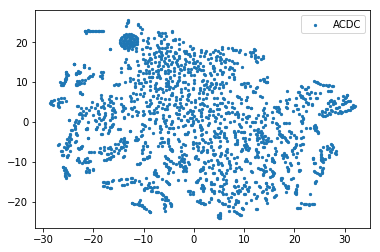

In [92]:
# scatter low dim vectors of acdc and gcn slices
plt.scatter(z_mean_comb_low_dim[:, 0], z_mean_comb_low_dim[:, 1], s=5, label='ACDC');
#plt.scatter(z_mean_comb_low_dim[1856:, 0], z_mean_comb_low_dim[1856:, 1], s=5, label='GCN');
plt.legend()
plt.show();

# Create clusters from low dimensional space vectors AFTER T-SNE, label scatter plot by this clusters

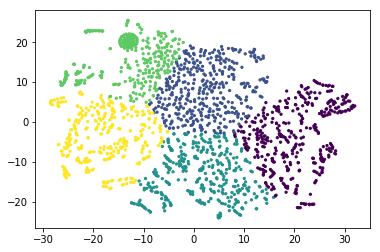

In [93]:
# find clusters with kmeans, after dimension reduction
from sklearn.cluster import KMeans
y_pred = KMeans(n_clusters=5, random_state=0).fit_predict(z_mean_comb_low_dim)
plt.scatter(z_mean_comb_low_dim[:, 0], z_mean_comb_low_dim[:, 1], c=y_pred, s=5)
df['cluster_5_tsne'] = y_pred

In [94]:
y_pred

array([4, 4, 4, ..., 0, 1, 3], dtype=int32)

# Create cluster from low dimensional space vectors BEFORE T-SNE, label by this clusters

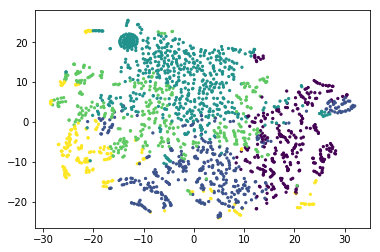

In [95]:
# find clusters with kmeans before dimension reduction
from sklearn.cluster import KMeans
y_pred = KMeans(n_clusters=5, random_state=0).fit_predict(z_means_acdc)
plt.scatter(z_mean_comb_low_dim[:, 0], z_mean_comb_low_dim[:, 1], c=y_pred, s=5)

# Low dimensional vectors AFTER T-SNE labeled by pathology, ACDC data

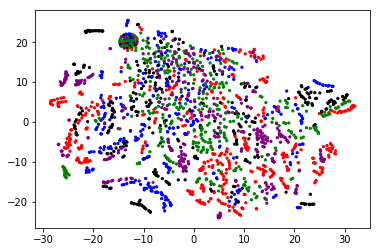

In [98]:
# group by pathology, trained on ACDC
z_mean_comb_low_dim_acdc = z_mean_comb_low_dim
#labels= df['pathologie'].astype('category').cat.codes.values
labels= df['pathologie'].values
plt.scatter(z_mean_comb_low_dim_acdc[:, 0], z_mean_comb_low_dim_acdc[:, 1], c=[color_dict[i] for i in labels], s=5)

# Filter slices by z-position

In [99]:
# format a string number to a fix length
format(int('1'), '02d')

'01'

In [100]:
# writer t and z into the dataframe
import re
def get_t_from_file(string):
    # find and return t in filename, cast to int, for later ordering
    return int(re.findall(r'_t(\d+)_', string)[0])

def get_z_from_file(string):
    # find and return z in filename, cast to int, for later ordering
    return int(re.findall(r'_z(\d+)_', string)[0])


# test the helpers
get_t_from_file(df['x_path'].values[0])
get_z_from_file(df['x_path'].values[0])


df['z_position'] = df.x_path.map(get_z_from_file)
df['t_position'] = df.x_path.map(get_t_from_file)

1

0

In [101]:
# show current df
df.head()

,Unnamed: 0,fold,x_path,y_path,modality,patient,pathologie,z_position,t_position,z_mean_10,z_mean_tsne_2,cluster_5_tsne
0,896,1,data/raw/ACDC/2D/train/patient082_t01_z0_img.nrrd,data/raw/ACDC/2D/train/patient082_t01_z0_msk.nrrd,train,patient082,RV,0,1,"[0.06334152817726135, 0.17303451895713806, -1....","[-25.757600784301758, -6.345424652099609]",4
1,897,1,data/raw/ACDC/2D/train/patient082_t01_z10_img....,data/raw/ACDC/2D/train/patient082_t01_z10_msk....,train,patient082,RV,10,1,"[-0.3347291052341461, 0.06687942147254944, 0.7...","[-23.001516342163086, -0.23401334881782532]",4
2,898,1,data/raw/ACDC/2D/train/patient082_t01_z11_img....,data/raw/ACDC/2D/train/patient082_t01_z11_msk....,train,patient082,RV,11,1,"[-0.4550430178642273, -0.005151420831680298, 0...","[-22.275442123413086, 1.0305854082107544]",4
3,899,1,data/raw/ACDC/2D/train/patient082_t01_z12_img....,data/raw/ACDC/2D/train/patient082_t01_z12_msk....,train,patient082,RV,12,1,"[-0.4441574811935425, 0.01940247416496277, 0.7...","[-22.152999877929688, 1.6714991331100464]",4
4,900,1,data/raw/ACDC/2D/train/patient082_t01_z13_img....,data/raw/ACDC/2D/train/patient082_t01_z13_msk....,train,patient082,RV,13,1,"[-0.4744008183479309, 0.05079874396324158, 0.7...","[-21.44744300842285, 2.2809693813323975]",4


# save and restore dataframe

In [169]:
# save df as temp df fo reusage
df.to_csv('reports/acdc_cut_by_mask_2d_fold1_description.csv')

In [131]:
df = df.sort_values(by=['patient', 't_position', 'z_position'])

In [5]:
df = pd.read_csv('reports/acdc_2d_fold1_description.csv')
# transform string of list to list
df['z_mean_tsne_2'] = df['z_mean_tsne_2'].map(lambda x : [float(n) for n in x.strip('[]').split(',')])

# Scatterplot low dimensional space group by z-position

In [6]:
# ACDC data
@interact
def scatter_low_dim_filter_by_z(z=(df.z_position.min(),df.z_position.max())):
    temp = df[df['z_position'] == z]
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    ax1 = sb.scatterplot(df['z_mean_tsne_2'].map(lambda x : x[0]), df['z_mean_tsne_2'].map(lambda x : x[1]), hue=df['z_position'], ax=ax1)
    ax1.set_title('Overview\n Low dim representation, grouped by z')
    
    ax2 = sb.scatterplot(df['z_mean_tsne_2'].map(lambda x : x[0]), df['z_mean_tsne_2'].map(lambda x : x[1]), hue=df['pathologie'], ax=ax2)
    sb.scatterplot(temp['z_mean_tsne_2'].map(lambda x : x[0]), temp['z_mean_tsne_2'].map(lambda x : x[1]), hue=df['pathologie'], s=500, ax=ax2, legend=False)
    ax2.set_title('Low dim representation\n marked z position = {}'.format(z))
    


interactive(children=(IntSlider(value=8, description='z', max=17), Output()), _dom_classes=('widget-interact',…

# Scatterplot low dimensional space, group by patients

In [7]:

@interact
def scatter_low_dim_filter_by_patient(patient=sorted(df['patient'].unique())):
    
    temp = df[df['patient'] == patient]

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25,10))
    
    ax1 = sb.scatterplot(temp['z_mean_tsne_2'].map(lambda x : x[0]), 
                         temp['z_mean_tsne_2'].map(lambda x : x[1]), 
                         hue=df['pathologie'], 
                         style=temp['t_position'],
                         size=temp['z_position'], 
                         sizes=(10,500), ax=ax1)
    ax1.set_title('Zoomed\n Low dim representation\n filtered by patient = {}'.format(patient))
    
    ax2 = sb.scatterplot(df['z_mean_tsne_2'].map(lambda x : x[0]), 
                         df['z_mean_tsne_2'].map(lambda x : x[1]), 
                         hue=df['pathologie'], ax=ax2)
    ax2 = sb.scatterplot(temp['z_mean_tsne_2'].map(lambda x : x[0]), 
                   temp['z_mean_tsne_2'].map(lambda x : x[1]), 
                   hue=df['pathologie'], s=500, legend=False, ax=ax2)
    ax2.set_title('Overview\n Low dim representation\n marked patient = {}'.format(patient))
    
    # get all images, sort by t and than by z
    images = sitk.GetArrayViewFromImage(sitk.ReadImage(temp.sort_values(by=['t_position', 'z_position'])['x_path'].values))
    print(images.shape)
    plot_3d_vol(img_3d=images)
    plt.show()

interactive(children=(Dropdown(description='patient', options=('patient001', 'patient002', 'patient003', 'pati…

# transform ACDC and GCN data with TSNE

In [ ]:
# concat gcn and acdc data, shrink dimensionality by TSNE
# concatenate both
z_mean_comb = np.concatenate([z_means_acdc, z_means_gcn])
logging.info(z_mean_comb.shape)
z_mean_comb_low_dim = TSNE(n_components=2, perplexity=100).fit_transform(z_mean_comb)
logging.info(z_mean_comb_low_dim.shape)

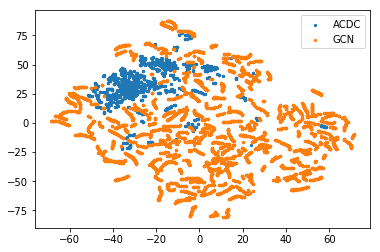

In [39]:
# scatter low dim vectors of acdc and gcn slices
plt.scatter(z_mean_comb_low_dim[:1856, 0], z_mean_comb_low_dim[:1856, 1], s=5, label='ACDC');
plt.scatter(z_mean_comb_low_dim[1856:, 0], z_mean_comb_low_dim[1856:, 1], s=5, label='GCN');
plt.legend()
plt.show();

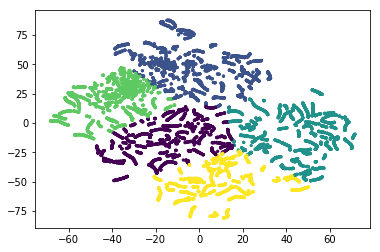

In [40]:
# find clusters with kmeans, after dimension reduction
from sklearn.cluster import KMeans
y_pred = KMeans(n_clusters=5, random_state=0).fit_predict(z_mean_comb_low_dim)
plt.scatter(z_mean_comb_low_dim[:, 0], z_mean_comb_low_dim[:, 1], c=y_pred, s=5)

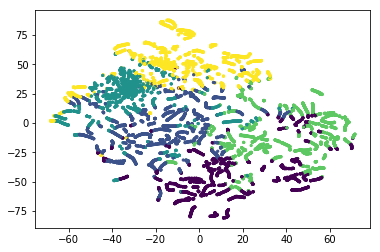

In [41]:
# find clusters with kmeans before dimension reduction
from sklearn.cluster import KMeans
y_pred = KMeans(n_clusters=5, random_state=0).fit_predict(z_mean_comb)
plt.scatter(z_mean_comb_low_dim[:, 0], z_mean_comb_low_dim[:, 1], c=y_pred, s=5)

In [60]:
# show all pathologies
df['pathologie'].unique()

array(['RV', 'NOR', 'MINF', 'HCM', 'DCM'], dtype=object)

In [97]:
# define colours
color_dict = { 'RV':'red', 'NOR':'blue', 'MINF':'black', 'HCM':'green','DCM':'purple' }
labels

array(['RV', 'RV', 'RV', ..., 'DCM', 'DCM', 'DCM'], dtype=object)

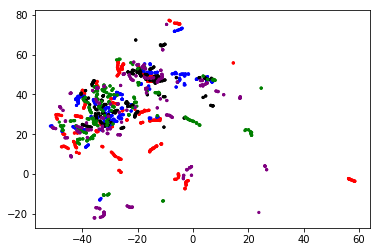

In [66]:
# group by pathologie
z_mean_comb_low_dim_gcn = z_mean_comb_low_dim[:1856, :]
#labels= df['pathologie'].astype('category').cat.codes.values
labels= df['pathologie'].values[:1856]
plt.scatter(z_mean_comb_low_dim_gcn[:, 0], z_mean_comb_low_dim_gcn[:, 1], c=[color_dict[i] for i in labels], s=5)

In [45]:
# inspect the gcn data set
@interact
def show_pred(img=(0,preds_gcn.shape[0])):
    print('selected: {}'.format(img))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # plot input and output
    ax1.imshow(x_trains_gcn[img,:,:,0])
    ax2.imshow(preds_gcn[img,:,:,0])
    
    # scatter low dim mean of this image
    f, ax3 = plt.subplots(1, 1, figsize=(10, 10))
    ax3.scatter(z_mean_comb_low_dim[:1856, 0], z_mean_comb_low_dim[:1856, 1], s=5, label='ACDC');
    ax3.scatter(z_mean_comb_low_dim[1856:, 0], z_mean_comb_low_dim[1856:, 1], s=5, label='GCN');
    z_mean_gcn_temp = z_mean_comb_low_dim[1856:, :]
    ax3.plot(z_mean_gcn_temp[img,0], z_mean_gcn_temp[img,1], 'r*', markersize = 20)
    ax3.legend()
    
    plt.show()

interactive(children=(IntSlider(value=5152, description='img', max=10304), Output()), _dom_classes=('widget-in…

In [28]:
df = df_folds[df_folds['fold'] == 1]
df.shape

(1884, 9)

In [30]:
df['x_path'].values

array(['data/raw/ACDC/2D/train/patient082_t01_z0_img.nrrd',
       'data/raw/ACDC/2D/train/patient082_t01_z10_img.nrrd',
       'data/raw/ACDC/2D/train/patient082_t01_z11_img.nrrd', ...,
       'data/raw/ACDC/2D/val/patient018_t10_z5_img.nrrd',
       'data/raw/ACDC/2D/val/patient018_t10_z6_img.nrrd',
       'data/raw/ACDC/2D/val/patient018_t10_z7_img.nrrd'], dtype=object)

In [46]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,fold,x_path,y_path,modality,patient,pathologie
896,896,896,0,1,data/raw/ACDC/2D/train/patient082_t01_z0_img.nrrd,data/raw/ACDC/2D/train/patient082_t01_z0_msk.nrrd,train,patient082,RV
897,897,897,1,1,data/raw/ACDC/2D/train/patient082_t01_z10_img....,data/raw/ACDC/2D/train/patient082_t01_z10_msk....,train,patient082,RV
898,898,898,2,1,data/raw/ACDC/2D/train/patient082_t01_z11_img....,data/raw/ACDC/2D/train/patient082_t01_z11_msk....,train,patient082,RV
899,899,899,3,1,data/raw/ACDC/2D/train/patient082_t01_z12_img....,data/raw/ACDC/2D/train/patient082_t01_z12_msk....,train,patient082,RV
900,900,900,4,1,data/raw/ACDC/2D/train/patient082_t01_z13_img....,data/raw/ACDC/2D/train/patient082_t01_z13_msk....,train,patient082,RV


In [ ]:
# tests
df = pd.read_csv('reports/acdc_2d_fold1_description.csv')
# transform string of list to list
df['z_mean_tsne_2'] = df['z_mean_tsne_2'].map(lambda x : [float(n) for n in x.strip('[]').split(',')])



In [33]:
img = sitk.GetArrayFromImage(sitk.ReadImage(df['x_path'].values[0]))

In [34]:
mask = sitk.GetArrayFromImage(sitk.ReadImage(df['y_path'].values[0]))

2019-09-25 16:30:02,941 INFO Image-shape: (154, 224)
2019-09-25 16:30:02,942 INFO Image data points: 34496
2019-09-25 16:30:02,943 INFO Image mean: 48.361
2019-09-25 16:30:02,943 INFO Image max: 255.000
2019-09-25 16:30:02,943 INFO Image min: 8.000
2019-09-25 16:30:02,943 INFO Mask-shape: (154, 224, 3)
2019-09-25 16:30:02,944 INFO RV mask data points: 1399
2019-09-25 16:30:02,945 INFO Myo mask data points: 562
2019-09-25 16:30:02,945 INFO LV mask data points: 819
2019-09-25 16:30:02,946 INFO RV mask 0.040555424988269806% of total pixels.
2019-09-25 16:30:02,946 INFO Myo mask 0.016291743144392967% of total pixels.
2019-09-25 16:30:02,946 INFO LV mask 0.023741882294416428% of total pixels.


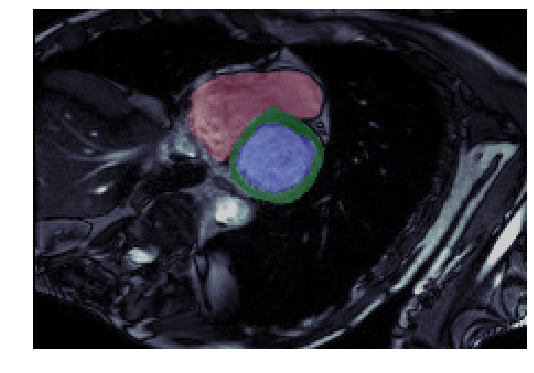

In [35]:
show_slice_transparent(img, mask)

In [36]:
img2 = img * mask

In [49]:
img.shape
mask.shape

(154, 224)

(154, 224)

2019-09-25 16:30:56,278 INFO Image-shape: (154, 224)
2019-09-25 16:30:56,279 INFO Image data points: 2780
2019-09-25 16:30:56,279 INFO Image mean: 16.538
2019-09-25 16:30:56,280 INFO Image max: 513.000
2019-09-25 16:30:56,280 INFO Image min: 0.000
2019-09-25 16:30:56,280 INFO Mask-shape: (154, 224, 3)
2019-09-25 16:30:56,281 INFO RV mask data points: 0
2019-09-25 16:30:56,281 INFO Myo mask data points: 0
2019-09-25 16:30:56,282 INFO LV mask data points: 0
2019-09-25 16:30:56,282 INFO RV mask 0.0% of total pixels.
2019-09-25 16:30:56,282 INFO Myo mask 0.0% of total pixels.
2019-09-25 16:30:56,283 INFO LV mask 0.0% of total pixels.


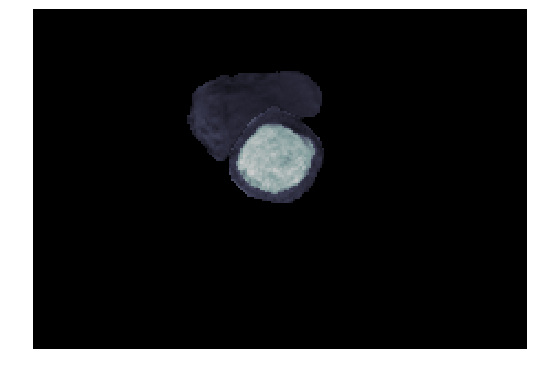

In [38]:
show_slice_transparent(img2)